<a href="https://colab.research.google.com/github/kimdesok/Atten_Deep_MIL/blob/master/Stock_daily_ML3ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Setting libraries and environment
> * Korean fonts installed
> * importing libraries for data manipulation, graphics, trend indicator calculation, etc
> * Downloading stock data and preparing them for the further processing
> * Downloading utility scripts

In [ ]:
#Korean fonts installation
# Rerun runtime
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#한글 폰트 지정
plt.rc('font', family='NanumBarunGothic') 

In [1]:
import urllib
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from urllib.request import urlopen
import seaborn as sns
# Plot a large graph
plt.figure(figsize = (16,12))

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

In [ ]:
#Ta-Lib library installation for calculating trend indicators

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install

# try below first
!pip install Ta-Lib
import talib

In [3]:
#KOSPI code + stock name
stock_type = {
    'kospi': 'stockMkt',
    'kosdaq': 'kosdaqMkt'
}

def get_code(df, names):
  codes = list()
  for name in names:
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    codes.append(code)
  return codes

def get_download_stock(market_type=None):
  market_type_param = stock_type[market_type]
  download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
  download_link = download_link + '?method=download'
  download_link = download_link + '&marketType=' + market_type_param

  df = pd.read_html(download_link, header=0)[0]
  return df;

def get_download_kospi():
  df = get_download_stock('kospi')
  df.종목코드 = df.종목코드.map('{:06d}'.format)
  return df

def get_download_kosdaq():
  df = get_download_stock('kosdaq')
  df.종목코드 = df.종목코드.map('{:06d}'.format)
  return df

kospi_df = get_download_kospi()
kosdaq_df = get_download_kosdaq()



In [4]:
code_df = pd.concat([kospi_df, kosdaq_df])
print(code_df.head())

code_df = code_df[['회사명', '종목코드']]

# data frame title 변경 '회사명' = name, 종목코드 = 'code'
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})


         회사명    종목코드           업종  ...      대표자명                    홈페이지     지역
0      DRB동일  004840     고무제품 제조업  ...       류영식     http://drbworld.com  부산광역시
1        DSR  155660  1차 비철금속 제조업  ...       홍석빈      http://www.dsr.com  부산광역시
2      GS글로벌  001250    상품 종합 도매업  ...       김태형  http://www.gsgcorp.com  서울특별시
3  HDC현대산업개발  294870       건물 건설업  ...  권순호, 정경구  http://www.hdc-dvp.com  서울특별시
4        KEC  092220      반도체 제조업  ...   박남규 김학남    http://www.kec.co.kr  서울특별시

[5 rows x 9 columns]


In [5]:
!rm -r marcap
!git clone "https://github.com/FinanceData/marcap.git" marcap

rm: cannot remove 'marcap': No such file or directory
Cloning into 'marcap'...
remote: Enumerating objects: 949, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 949 (delta 51), reused 69 (delta 48), pack-reused 877
Receiving objects: 100% (949/949), 2.09 GiB | 43.79 MiB/s, done.
Resolving deltas: 100% (559/559), done.
Checking out files: 100% (39/39), done.


In [ ]:
#!ls -lh marcap/data 
!cp -r  marcap '/content/drive/MyDrive/marcap'

In [ ]:
!cp -r '/content/drive/MyDrive/marcap'  marcap

In [ ]:
from marcap import marcap_data
from datetime import date
today = date.today()

#Select dates
start_date = '2018-01-01'
stock_data = marcap_data(start_date, today)
#print(stock_data[['Code', 'Name', 'Open', 'High', 'Low', 'Close', 'Volume']].tail(10))

#For this exercise, we need two dataframes
lng_df = stock_data[stock_data['Name'] == '피씨엘']
spy_df = stock_data[stock_data['Name'] == '이아이디']

print(lng_df[['Code', 'Name', 'Open', 'High', 'Low', 'Close', 'Volume']])
print(spy_df[['Code', 'Name', 'Open', 'High', 'Low', 'Close', 'Volume']])

print(lng_df.info())
print(spy_df.info())

In [19]:
#Data transform using the close price
lng_df = lng_df.pivot_table(index='Date', values=['Close', 'Volume'])
lng_df.columns = ['Adj_Close', 'Adj_Volume']
print(lng_df.tail())
spy_df = spy_df.pivot_table(index='Date', values=['Close', 'Volume'])
spy_df.columns = ['Adj_Close', 'Adj_Volume']
print(spy_df.tail())

            Adj_Close  Adj_Volume
Date                             
2021-07-30      51700      351393
2021-08-02      49100      112441
2021-08-03      47900       96858
2021-08-04      49900      190980
2021-08-05      49900       40665
            Adj_Close  Adj_Volume
Date                             
2021-07-30        530    20461810
2021-08-02        538    23267012
2021-08-03        516    24302227
2021-08-04        527    49134545
2021-08-05        527    15814884


##2. Explorative Data Analysis 
> * Data produced previously utilized in this exercise
> * Almost similar to Stock-daily-ML1.ipynb

In [ ]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

In [44]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:
  
    #Ta-Lib methods do not like real data so transform them to double floats.
    lng_df_float = np.array(lng_df['Adj_Close'].values, dtype='f8')
    
    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df_float,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df_float, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [45]:
# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct'].values

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct  ...     ma200    rsi200
5d_close_future_pct             1.000000      0.029967  ...  0.108204 -0.112579
5d_close_pct                    0.029967      1.000000  ... -0.292334  0.259195
ma14                            0.012178     -0.840401  ...  0.342748 -0.310836
rsi14                          -0.019215      0.643543  ... -0.513698  0.527232
ma30                            0.049602     -0.649748  ...  0.485392 -0.436657
rsi30                          -0.089027      0.549341  ... -0.684689  0.702060
ma50                            0.090015     -0.525176  ...  0.618021 -0.542448
rsi50                          -0.121748      0.484268  ... -0.812585  0.834788
ma200                           0.108204     -0.292334  ...  1.000000 -0.939015
rsi200                         -0.112579      0.259195  ... -0.939015  1.000000

[10 rows x 10 columns]


In [46]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * linear_features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(472, 10) (401, 10) (71, 10)


In [ ]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

In [ ]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values, timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

In [49]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 6)])
lng_df.dropna(inplace=True)  # drop missing values in-place
print(lng_df.head())

            Adj_Close  Adj_Volume  ...  weekday_3  weekday_4
Date                               ...                      
2019-09-03       7620       30516  ...          0          0
2019-09-04       7600        8608  ...          0          0
2019-09-05       7520       13640  ...          1          0
2019-09-06       7520        9418  ...          0          1
2019-09-09       7490       10605  ...          0          0

[5 rows x 23 columns]


In [50]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * linear_features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(472, 10) (401, 10) (71, 10)


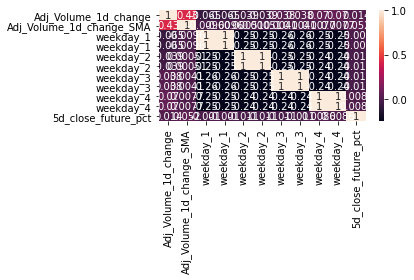

In [51]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

##3. Machine Learning - Tree Methods
> * Decision Trees
> * Random Forests

In [52]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features , train_targets)
#print(train_features) 
#Too many features but little data. Remove irrelevant features by factor analysis or something
# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features , test_targets))

0.9999999621656938
-0.31784399371602734


In [53]:
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features , train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.2251136367261375
-0.5069471461447226 

max_depth= 5
0.3664811921366692
-0.15192773096171466 

max_depth= 10
0.8546575776308554
-0.13140987866356446 



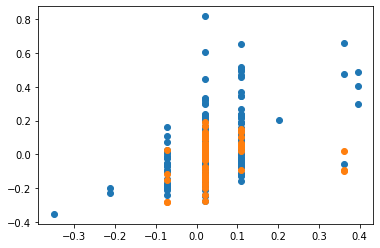

In [54]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(
test_features)
# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

In [55]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
#x, Y
rfr.fit(train_features , train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8968113607303648
-0.22975177816666514


In [56]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators' : [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features , train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.08291823253699837 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


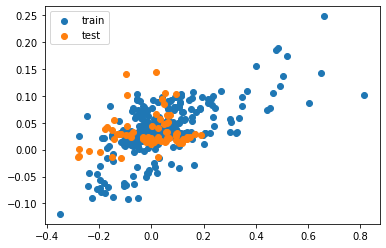

In [57]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

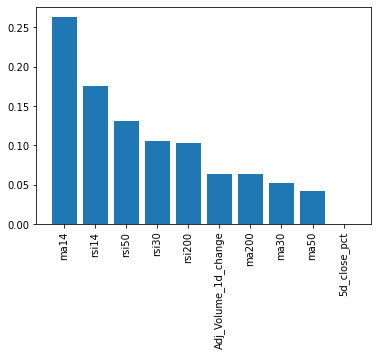

In [58]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [59]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.39600372240712345
-0.18465616077017602


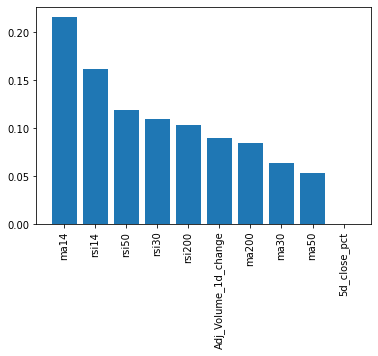

In [60]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1] + 1) # X needs to be identical to the number of features

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

##4. Neural Network 
> * Standardizing data
> * K-nearest neighbors(KNN)
> * Neural networks

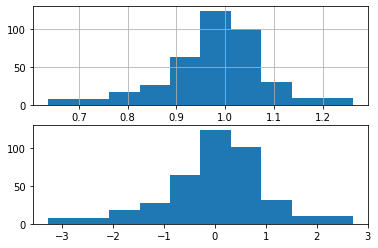

In [61]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]
#test_features = train_features?

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

In [62]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2, 13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.650326374519225
-1.5380567656192783

n_neighbors = 3
train, test scores
0.5358489745941589
-1.2082009655291674

n_neighbors = 4
train, test scores
0.4532113989420916
-1.0653748049100877

n_neighbors = 5
train, test scores
0.38601061749948595
-1.0133360833307932

n_neighbors = 6
train, test scores
0.3099553692192427
-1.2030299147726917

n_neighbors = 7
train, test scores
0.28185755151027114
-1.1032306818620352

n_neighbors = 8
train, test scores
0.27042612082884354
-0.9834253044326442

n_neighbors = 9
train, test scores
0.2440504164549553
-0.8990833354054366

n_neighbors = 10
train, test scores
0.23018400286149876
-0.8578598245551523

n_neighbors = 11
train, test scores
0.22664823356039887
-0.7618432274326412

n_neighbors = 12
train, test scores
0.2270806085504382
-0.7105723943788018



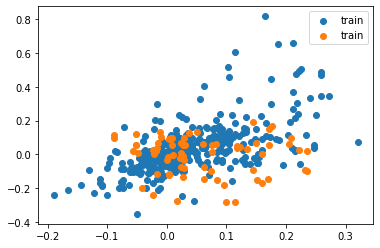

In [63]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='train')
plt.legend()
plt.show()